# Comparison of nuclear sizes across different tissues in emi and control embryos

In [1]:
from cellpose import models
from cellpose.io import imread
from skimage import io as skio
from skimage import measure, transform, morphology, filters
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from parse import parse
import colorcet as cc
import os
import sys
from scipy import ndimage
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from aicsimageio import AICSImage
import aicsimageio
import xml.etree.ElementTree as ET
import seaborn as sns
from tqdm import tqdm
import tifffile as tif
import pickle
import time
plt.style.use("E:/Documents/Cohen Lab/bio_publications.mplstyle")

In [2]:
rootdir = Path("E:/Documents/Cohen Lab/Papers/Kalki_CellCycle/20240409_tissue_nuclear_size_comparison_emi_ctrl")
all_data = {}


In [3]:
def write_imagej_file(img, filepath, dx=1, dz=1):
    with open("E:/Documents/Cohen Lab/Code/imagej_metadata_template.pkl", "rb") as f:
        imagej_metadata = pickle.load(f)

    imagej_metadata['images'] = np.prod(img.shape[:3])
    imagej_metadata['spacing'] = dz
    imagej_metadata['min'] = np.min(img[0,:,1,:,:])
    imagej_metadata['max'] = np.max(img[0,:,1,:,:])
    imagej_metadata['Ranges'] = (np.min(img[:,:,0,:,:]), np.max(img[:,:,0,:,:]), np.min(img[:,:,1,:,:]), np.max(img[:,:,1,:,:]))
    page_labels = []
    for i in range(img.shape[1]):
        for j in range(img.shape[2]):
            page_labels.append(f"c:{j+1}/{img.shape[2]}, z:{i+1}/{img.shape[1]} - Series0")
    imagej_metadata['Labels'] = page_labels
    imagej_metadata['Info'] = f"BitsPerPixel = 16\n DimensionOrder = XYCZT\n IsInterleaved = false\n IsRGB = false\n LittleEndian = true\n PixelType = uint16\n Series 0 Name = null\n SizeC = {img.shape[2]}\n SizeT = {img.shape[0]}\n SizeX = {img.shape[4]}\n SizeY = {img.shape[3]}\n SizeZ = {img.shape[1]}\n \Location = {filepath}"
    tif.imwrite(filepath, img, imagej=True, metadata=imagej_metadata, resolution=[1/dx, 1/dx])



## Run nuclear segmentation using cellpose

In [15]:
timepoints = ["Ctrl", "emi1", "HUA"]

cell_sizes = [23, 23, 23]
flow_thresholds = [0.2, 0.2, 0.2]
target_dx = np.array([0.414, 0.414, 0.414])
model = models.Cellpose(gpu=True, model_type="cyto2")


In [16]:
for idx in range(2,3):
    condition = timepoints[idx]
    combined_props = pd.DataFrame()
    subfolder = rootdir
    os.makedirs(rootdir/"analysis"/condition/"masks", exist_ok=True)
    czi_files = list(subfolder.glob("*.czi"))
    parse_format = "DRAQ7_{immunostain}_{condition}_24hpf_{tissue}_E{embryo:d}-{num:2d}.czi"
    curr_condition_files = [czi_file for czi_file in czi_files if condition in czi_file.name]
    for czi_file in tqdm(curr_condition_files):
        # start_time = time.time()

        file_info = parse(parse_format, czi_file.name)
        czi = AICSImage(czi_file)
        x = czi.metadata.find("Metadata")
        # Find the element "Scaling" recursively in the children of x
        scaling = x.find(".//Scaling")
        # Find the element "Distance" with attribute "Id" equal to "X"
        dx = float(scaling.find(".//Distance[@Id='X']").find("Value").text)*1e6
        dz = float(scaling.find(".//Distance[@Id='Z']").find("Value").text)*1e6
        print(f"dx: {dx}, dz: {dz}")
        print("Channels:", czi.channel_names)
        # Find element of czi.channel_names that contains "AF633"
        nuc_channel = [i for i, s in enumerate(czi.channel_names) if "AF633" in s][0]
        img = czi.get_image_data("ZYXC", C=[nuc_channel])
        img = ndimage.median_filter(img, footprint=np.ones((1,3,3,1)))
        downsample_factor = np.round(dx/target_dx[idx], decimals=2)
        print(f"Downsampling by {downsample_factor}x")
        print(img.shape)
        if downsample_factor != 1:
            img=transform.rescale(img, (1, downsample_factor, downsample_factor, 1), anti_aliasing=True, preserve_range=True, order=1)
        print(img.shape)

        # Run cellpose
        cell_size = cell_sizes[idx]
        flow_threshold = flow_thresholds[idx]
        masks, flows, styles, diams = model.eval(img[:,:,:,0], diameter=cell_size, channels=[0,0], 
                                                    do_3D=True, anisotropy=dz/(target_dx[idx]), min_size=600, flow_threshold=flow_threshold)
        filepath = str(rootdir/"analysis"/condition/"masks"/f"{file_info['condition']}_{file_info['immunostain']}_{file_info['tissue']}_E{file_info['embryo']}_mask.tif")
        mask_overlay = np.zeros((1,masks.shape[0],2,masks.shape[1], masks.shape[2]), dtype=np.uint16)
        mask_overlay[0,:,0,:,:] = img[:,:,:,0]
        mask_overlay[0,:,1,:,:] = masks
        write_imagej_file(mask_overlay, filepath, dx=target_dx[idx], dz=dz)
        
        
        # Measure properties of the masks
        props = measure.regionprops_table(masks, properties=["label", "area", "centroid"])
        props = pd.DataFrame(props)
        props["immunostain"] = file_info["immunostain"]
        props["embryo"] = file_info["embryo"]
        props["condition"] = file_info["condition"]
        props["tissue"] = file_info["tissue"]
        props["volume_um3"] = props["area"] * dz*(target_dx[idx])**2

        
        # Collect and save results
        props.to_csv(rootdir/"analysis"/condition/f"{file_info['condition']}_{file_info['immunostain']}_{file_info['tissue']}_E{file_info['embryo']}_props.csv", index=False)
        combined_props = pd.concat([combined_props, props], axis=0)
        combined_props.to_csv(rootdir/"analysis"/condition/f"combined_props_{condition}.csv", index=False)b
    all_data[condition] = combined_props


  0%|          | 0/5 [00:00<?, ?it/s]

dx: 0.1325828125, dz: 0.7599999999999998
Channels: ['AF633']
Downsampling by 0.32x
(50, 1600, 1600, 1)
(50, 512, 512, 1)


 20%|██        | 1/5 [00:42<02:50, 42.71s/it]

dx: 0.1325828125, dz: 0.7599999999999998
Channels: ['AF633']
Downsampling by 0.32x
(35, 1600, 1600, 1)
(35, 512, 512, 1)


 40%|████      | 2/5 [01:07<01:36, 32.28s/it]

dx: 0.1325828125, dz: 0.7599999999999998
Channels: ['AF633']
Downsampling by 0.32x
(58, 1600, 1600, 1)
(58, 512, 512, 1)


 60%|██████    | 3/5 [01:47<01:11, 35.76s/it]

dx: 0.1325828125, dz: 0.7599999999999998
Channels: ['AF633']
Downsampling by 0.32x
(49, 1600, 1600, 1)
(49, 512, 512, 1)


 80%|████████  | 4/5 [02:24<00:36, 36.18s/it]

dx: 0.1325828125, dz: 0.7599999999999998
Channels: ['AF633']
Downsampling by 0.32x
(54, 1600, 1600, 1)
(54, 512, 512, 1)


100%|██████████| 5/5 [03:01<00:00, 36.23s/it]


NameError: name 'all_data' is not defined

### Clean up segmentation data

In [17]:
# group all timepoints
all_data = pd.concat([pd.read_csv(rootdir/"analysis"/condition/f"combined_props_{condition}.csv") for condition in timepoints], axis=0)
all_data.to_csv(rootdir/"analysis"/"all_data_combined.csv", index=False)

In [20]:
all_timepoint_data = pd.read_csv(rootdir/"analysis"/"all_data_combined.csv")
all_timepoint_data["genotype"] = all_timepoint_data["condition"].map({"emi1": "hi2648", "Ctrl": "Ctrl", "HUA": "HUA"})
all_timepoint_data["tissue"] = all_timepoint_data["tissue"].map({"myotome": "Trunk muscle", "hindbrain": "Hindbrain", "neuraltube": "Neural tube"})
all_timepoint_data.loc[:, "sample"] = all_timepoint_data.apply(lambda x: f"{x['genotype']}_{x['immunostain']}_{x['tissue']}_E{x['embryo']}", axis=1)


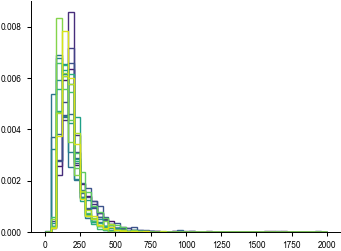

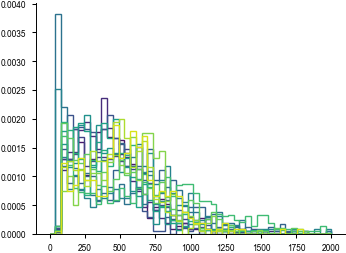

In [33]:
colormap = sns.color_palette("viridis", 15)
for idx, (name, group) in enumerate(all_timepoint_data.groupby("genotype")):
    fig, ax = plt.subplots(figsize=(4,3))
    for idx2, (name2, group2) in enumerate(group.groupby("sample")):
        ax.hist(group2["volume_um3"], bins=np.linspace(0, 2000, 50), histtype="step", color=colormap[idx2], label=name2, density=True)

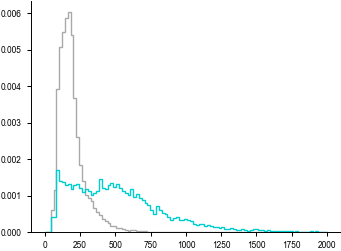

In [34]:
cs = ["#A9A9A9", "#00CDCD", "#E78AC3"]
fig, ax = plt.subplots(figsize=(4,3))
for idx, (name, group) in enumerate(all_timepoint_data.groupby("genotype")):
    ax.hist(group["volume_um3"], bins=np.linspace(0, 2000, 100), label=name, alpha=1, density=True, color=cs[idx], histtype="step")

In [23]:
nuc_size_cutoff = 80
df_filtered = pd.DataFrame(all_timepoint_data.loc[all_timepoint_data["volume_um3"] > nuc_size_cutoff,:])
df_filtered.to_csv(rootdir/"analysis"/"filtered_props.csv", index=False)

In [8]:
df_filtered = pd.read_csv(rootdir/"analysis"/"filtered_props.csv")

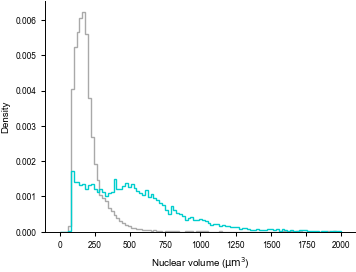

In [36]:
cs = ["#A9A9A9", "#00CDCD", "#E78AC3"]
fig, ax = plt.subplots(figsize=(4,3))
for idx, (name, group) in enumerate(df_filtered.groupby("genotype")):
    ax.hist(group["volume_um3"], bins=np.linspace(0,2000, 100), label=name, alpha=1, density=True, color=cs[idx], histtype="step")
ax.set_xlabel(r"Nuclear volume ($\mathrm{\mu m^3}$)")
ax.set_ylabel("Density")
plt.savefig(rootdir/"analysis"/f"nuclear_volume_distribution_filtered.svg")

In [24]:
# Plot median nuclear volume per sample grouped by genotype and timepoint
median_nuclear_volume = df_filtered.groupby(["sample"]).agg({"volume_um3": "median", "genotype": "first", "tissue": "first"}).reset_index()
median_nuclear_volume["timepoint"] = "24hpf"
median_nuclear_volume.to_csv(rootdir/"analysis"/"median_nuclear_volume.csv", index=False)

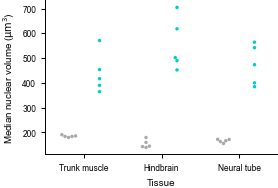

In [39]:
fig1, ax1 = plt.subplots(figsize=(3,2))
hue_order = ["Ctrl", "hi2648"]
cs = ["#A9A9A9", "#00CDCD"]

sns.swarmplot(data=median_nuclear_volume, x="tissue", y="volume_um3", hue="genotype", hue_order=hue_order, dodge=True, ax=ax1, size=2.5, palette=cs)
ax1.set_xlabel("Tissue")
ax1.set_ylabel(r"Median nuclear volume ($\mathrm{\mu m^3}$)")
# Hide legend
ax1.legend().set_visible(False)
# plt.savefig(rootdir/"analysis"/f"median_nuclear_volume_per_sample.svg")